In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

# Introduction

The following notebook contains introduction into the data we are going to use for the challenge.

The data used for the challenge contains glitches (transient noise events) mimicking real astrophysical signal and influencing the data quality. 

The data has been split into two parts:

1. `gspy*csv` - this file contains metadata describing each glitch like GPS time, its frequency etc.

2. `hdf5` - this directory contains 6667 files; each of them stores time-series data of the glitch

Each time series file is named according to the following schema:

`InterferometerName_GlitchId_GlitchGPS.GlitchGPS_miliseconds.hdf5`

Example:

`L1_ZzK9qapmuh_1127563548.0_7.hdf5`

Let's start from having a look at the metadata.

In [ ]:
data_dir = os.path.join(os.path.dirname(os.getcwd()),"data")

In [3]:
metadata_filename = "gspy-db-20180813_O1_filtered_t1126400691-1205493119_snr7.5_tr_gspy.csv"

metadata_df = pd.read_csv(os.path.join(data_dir,metadata_filename))

In [4]:
metadata_df.head()

,GPStime,peakFreq,snr,centralFreq,duration,bandwidth,id,ifo,label
0,1.134828e+09,32.246,40.137,1601.119,7.250,3183.373047,LYD73IJEbP,H1,Scattered_Light
1,1.134164e+09,29.897,38.256,2965.068,2.500,5894.235352,kQOi8X6807,H1,Scattered_Light
2,1.134478e+09,29.636,32.589,41.479,2.313,47.056068,wypbhS6TAa,H1,Scattered_Light
3,1.134478e+09,31.943,29.462,2532.243,3.000,5035.515137,aKFWKfLE8l,H1,Scattered_Light
4,1.137056e+09,32.552,28.537,1167.148,4.750,2324.383057,yWSM6mnbBM,H1,Scattered_Light


As you can see above, each glitch is described by the set of 9 parameters:

1. GPStime - GPS time of the first peak

2. peakFreq - frequency of the strongest peak of time series signal

3. snr - Signal to Noise Ration of the glitch

4. centralFreq - central frequency of the signal

5. duration - duration of the glitch in the time series data

6. bandwidth - bandwidth of the signal

7. id - id of the glitch; this parameter is used to find a particular file with time-series in the `hdf5` directory

8. ifo - name of the interferometer; in the challenge we use H1 and L1 (Hanford and Livingstone Interferometers)

9. label - type of the glitch

The useful informations (physical) are stored only in the field 2-6.

Let's now check what types of glitches we have in our data.

In [5]:
metadata_df["label"].unique()

array(['Scattered_Light', 'Repeating_Blips', 'Violin_Mode', 'Power_Line',
       'Whistle', 'Scratchy', 'Helix', 'Light_Modulation',
       'Wandering_Line', 'Low_Frequency_Burst', 'Koi_Fish',
       'Low_Frequency_Lines', 'Blip', '1400Ripples', 'Chirp',
       'Extremely_Loud', 'None_of_the_Above', 'Paired_Doves', 'Tomte',
       'Air_Compressor', 'No_Glitch', '1080Lines'], dtype=object)

In [6]:
metadata_df.groupby("label")["id"].nunique()

label
1080Lines                 4
1400Ripples              83
Air_Compressor           57
Blip                   1763
Chirp                    60
Extremely_Loud          448
Helix                   270
Koi_Fish                709
Light_Modulation        400
Low_Frequency_Burst     527
Low_Frequency_Lines     494
No_Glitch                41
None_of_the_Above       151
Paired_Doves             26
Power_Line              450
Repeating_Blips          91
Scattered_Light         427
Scratchy                269
Tomte                    93
Violin_Mode             137
Wandering_Line           21
Whistle                 146
Name: id, dtype: int64

In total we have 22 classes or rather 21 glitch types and the noise `No_Glitch`. As er can see the data is not balanced.

# Visualization

Knowing what kind of data we have in our dataset, let's now try to plot it. For this we need to use `id` field from metadata to find particular hdf5 file.

Let's try to plot `Blip` as the most common in the dataset.

In [7]:
blip_df = metadata_df.loc[metadata_df["label"]=="Blip"]

In [8]:
blip_df.head()

,GPStime,peakFreq,snr,centralFreq,duration,bandwidth,id,ifo,label
1071,1.136353e+09,170.654,25.765,452.496,0.313,800.075928,m44eQDjFmi,H1,Blip
1143,1.128036e+09,99.067,10.888,131.310,0.156,144.076462,E5aPQop6HO,H1,Blip
1178,1.136399e+09,137.711,12.734,2396.786,0.826,4688.654785,6zEEDplpiy,L1,Blip
1185,1.128869e+09,121.663,16.776,217.960,0.188,317.377319,vV1Rk05tUQ,H1,Blip
1231,1.128502e+09,149.414,12.544,189.742,0.109,233.902252,E7JXjEBeSy,L1,Blip


In [9]:
glitch_metadata = blip_df.iloc[0]
print(glitch_metadata)

GPStime        1.13635e+09
peakFreq           170.654
snr                 25.765
centralFreq        452.496
duration             0.313
bandwidth          800.076
id              m44eQDjFmi
ifo                     H1
label                 Blip
Name: 1071, dtype: object


GPStime in the metadata and the name of hdf5 are different so we can't use it to create filename. Instead let's try to use only `id` and search for the file in the directory.

In [10]:
glitch_id = glitch_metadata["id"]

In [ ]:
data_dir_hdf5 = os.path.join(os.path.dirname(os.getcwd()),"data") + "/hdf5"

In [12]:
for file in os.listdir(data_dir_hdf5):
    if glitch_id in file:
        glitch_filename = file

In [13]:
h5=h5py.File(os.path.join(data_dir_hdf5, glitch_filename), 'r')

Important info! If the hdf is opened elsewhere, you will get an error saying "Resource temporarily unavailable".

If you want to use it here, you need to close it elsewhere.

The content of the file is the following:

-  Strain
    -  Strain:
        -  value
        -  attributes:
            1. GPSstart
            2. GPSend
            3. Sample_Rate
            4. Ifo

In [14]:
GPSstart = h5["Strain"]["Strain"].attrs["GPSstart"]
GPSend = h5["Strain"]["Strain"].attrs["GPSend"]
Sample_Rate = h5["Strain"]["Strain"].attrs["Sample_Rate"]
Ifo = h5["Strain"]["Strain"].attrs["Ifo"]
print ('GPSstart',GPSstart)
print ('GPSend',GPSend)
print ('Sample_Rate',Sample_Rate)
print ('Ifo',Ifo)

GPSstart 1136353323.8
GPSend 1136353327.8
Sample_Rate 4096.0
Ifo b'H1'


Now, let's plot the time-series

In [15]:
strain = h5["Strain"]["Strain"].value
ts = 1./Sample_Rate
half = (GPSend-GPSstart)/2.
time = np.arange(-half,half,ts)

Text(0, 0.5, 'Strain')

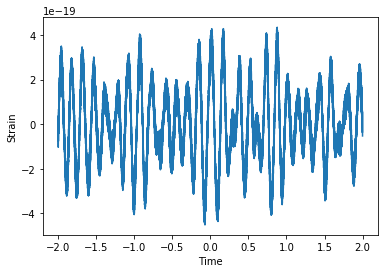

In [16]:
plt.plot(time, strain)
plt.xlabel("Time")
plt.ylabel("Strain")

Voila!

Don't forget to close hdf5 file when you're done!

In [17]:
h5.close()